<a href="https://colab.research.google.com/github/ealeongomez/Deep-Learning/blob/master/CNN_TF_Reg_Voltage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!git clone https://github.com/ealeongomez/Data

Cloning into 'Data'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 49 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [19]:
cd Data/

/content/Data/Data


In [20]:
!unzip household_power_consumption.csv.zip

Archive:  household_power_consumption.csv.zip
  inflating: household_power_consumption.csv  
  inflating: __MACOSX/._household_power_consumption.csv  


In [21]:
# Basic packages
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Machine learning packages 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Métricas de rendimiento
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

# Deep Learning
import tensorflow as tf
from tensorflow import keras

#**Load data**

In [22]:
dataset = pd.read_csv('household_power_consumption.csv',
                      header=0,
                      infer_datetime_format=True,
                      parse_dates=['datetime'], 
                      index_col=['datetime'])

dataset.head

<bound method NDFrame.head of                      Global_active_power  ...  sub_metering_4
datetime                                  ...                
2006-12-16 17:24:00                4.216  ...       52.266670
2006-12-16 17:25:00                5.360  ...       72.333336
2006-12-16 17:26:00                5.374  ...       70.566666
2006-12-16 17:27:00                5.388  ...       71.800000
2006-12-16 17:28:00                3.666  ...       43.100000
...                                  ...  ...             ...
2010-11-26 20:58:00                0.946  ...       15.766666
2010-11-26 20:59:00                0.944  ...       15.733334
2010-11-26 21:00:00                0.938  ...       15.633333
2010-11-26 21:01:00                0.934  ...       15.566667
2010-11-26 21:02:00                0.932  ...       15.533334

[2075259 rows x 8 columns]>

In [23]:
dataset.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'sub_metering_4'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


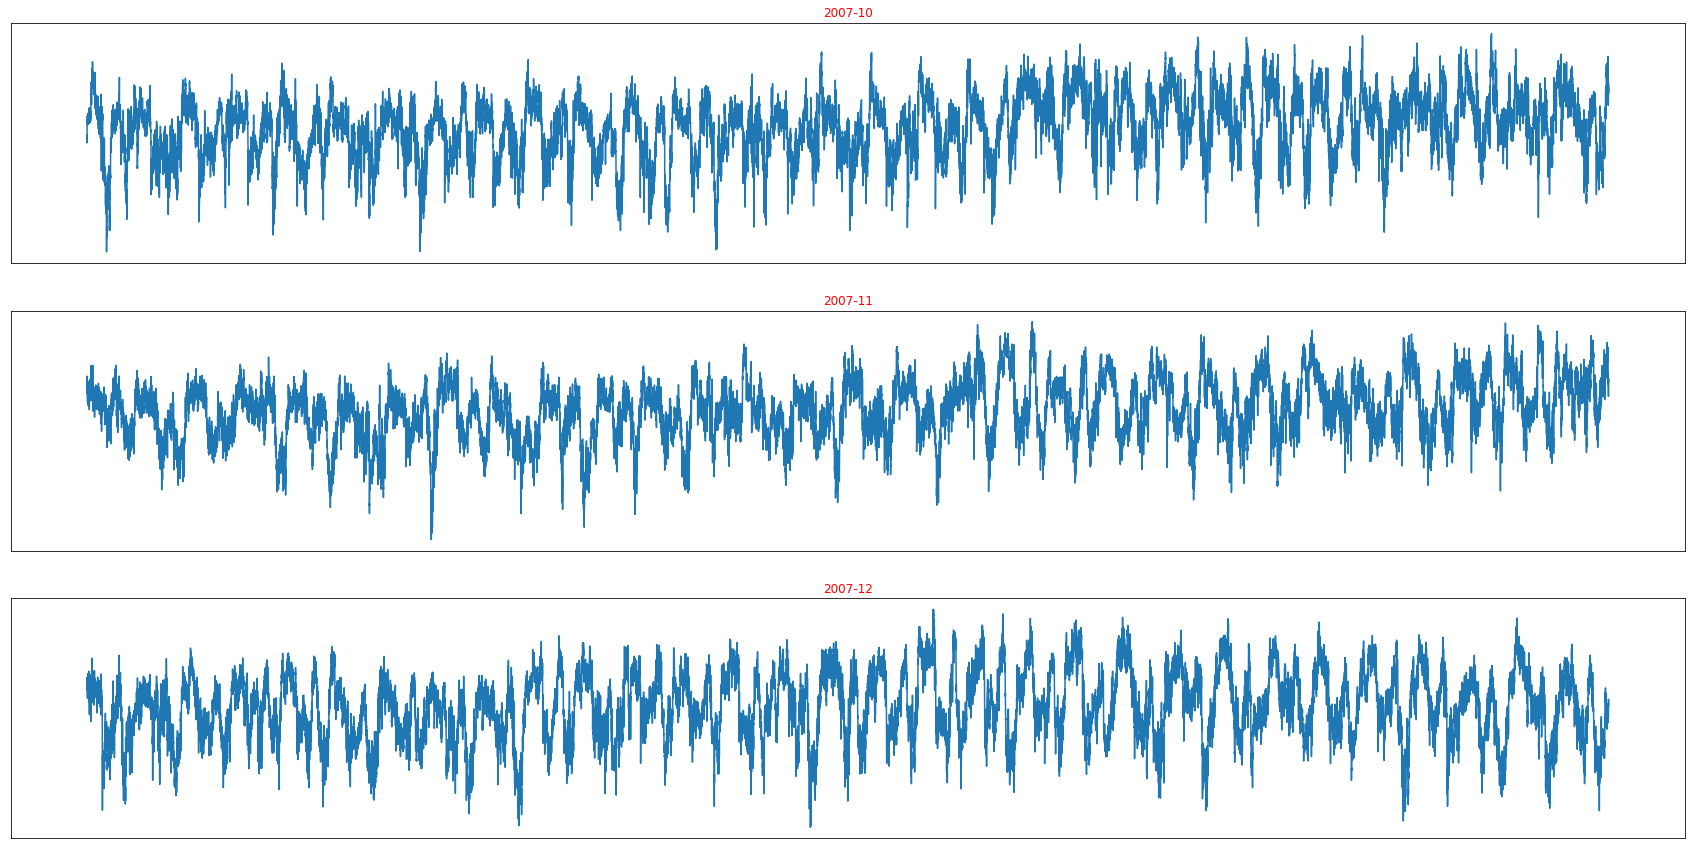

In [24]:
# Plot active power for each year
months = [x for x in range(10, 13)]

plt.figure(figsize=(30, 15))
for i in range(len(months)):
  # Prepare subplot
  ax = plt.subplot(len(months), 1, i+1)
  # Determine the month to plot
  month = '2007-' + str(months[i])

  # Get all observations for the month
  result = dataset[month]
  timeSerie = result['Voltage']

  timeSerie.replace(np.nan, np.mean(timeSerie), inplace=True)

  # Plot the active power for the month
  plt.plot(timeSerie)
  # Add a title to the subplot
  plt.title(month, c='r')
  # Turn off ticks to remove clutter
  plt.yticks([]); plt.xticks([])
  plt.grid(True)
  
plt.show()



In [25]:
np.mean(timeSerie)

241.72576289791397

In [26]:
#t = timeSerie.to_numpy()

#print(type(timeSerie), type(t))

In [27]:
timeSerie = (timeSerie-min(timeSerie))/(max(timeSerie)-min(timeSerie))  

window = 10 # Size of array 

X = np.zeros([len(timeSerie)-window, window])
for i in range(len(timeSerie)-window):
  X[i,:] = timeSerie[i:i+window].T
# Vector de salida (pronostico de nuestro modelo)
y = timeSerie[window:]

X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2, random_state=42)

X_train, y_train = X_train[:,:,np.newaxis], y_train[:,np.newaxis]
X_valid, y_valid = X_valid[:,:,np.newaxis], y_valid[:,np.newaxis]
X_test, y_test = X_test[:,:,np.newaxis], y_test[:,np.newaxis]

X_train = np.asarray(X_train).astype('float32')
X_valid = np.asarray(X_valid).astype('float32')
X_test = np.asarray(X_test).astype('float32')

y_train = np.asarray(y_train).astype('float32')
y_valid = np.asarray(y_valid).astype('float32')
y_test = np.asarray(y_test).astype('float32')

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  app.launch_new_instance()


((28563, 10, 1),
 (28563, 1),
 (7141, 10, 1),
 (7141, 1),
 (8926, 10, 1),
 (8926, 1))

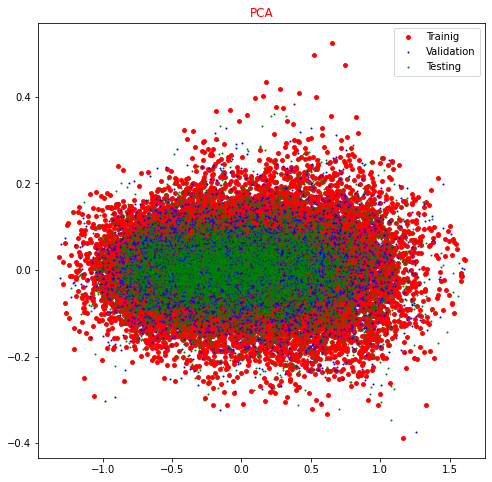

In [28]:
# Analisis exploratorio de los datos
pca = PCA(n_components = 2)
tranformed_pca_train = pca.fit_transform(np.squeeze(X_train))
tranformed_pca_valid = pca.fit_transform(np.squeeze(X_valid))
tranformed_pca_test = pca.fit_transform(np.squeeze(X_test))

plt.figure(figsize=(8, 8))
plt.title("PCA", c='r')
plt.scatter(tranformed_pca_train[:,0], tranformed_pca_train[:,1], s=15, c='r', label='Trainig')
plt.scatter(tranformed_pca_valid[:,0], tranformed_pca_valid[:,1], s=1, c='b', label='Validation')
plt.scatter(tranformed_pca_test[:,0], tranformed_pca_test[:,1], s=1, c='g', label='Testing')
plt.legend()
plt.show()

In [29]:
# Define model
model = keras.models.Sequential()

model.add(keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.MaxPooling1D(pool_size=2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='relu'))
model.add(keras.layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 8, 128)            512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 5,653
Trainable params: 5,653
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(loss='mse', metrics=['mae', 'mse'], optimizer='SGD')

history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_valid, y_valid), 
                    batch_size=300 
                    )

Epoch 1/10
96/96 [==============================] - 1s 6ms/step - loss: 0.0397 - mae: 0.1381 - mse: 0.0397 - val_loss: 0.0082 - val_mae: 0.0726 - val_mse: 0.0082
Epoch 2/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0075 - mae: 0.0697 - mse: 0.0075 - val_loss: 0.0068 - val_mae: 0.0660 - val_mse: 0.0068
Epoch 3/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0063 - mae: 0.0636 - mse: 0.0063 - val_loss: 0.0058 - val_mae: 0.0605 - val_mse: 0.0058
Epoch 4/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0053 - mae: 0.0582 - mse: 0.0053 - val_loss: 0.0049 - val_mae: 0.0551 - val_mse: 0.0049
Epoch 5/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0045 - mae: 0.0531 - mse: 0.0045 - val_loss: 0.0042 - val_mae: 0.0509 - val_mse: 0.0042
Epoch 6/10
96/96 [==============================] - 0s 4ms/step - loss: 0.0039 - mae: 0.0493 - mse: 0.0039 - val_loss: 0.0037 - val_mae: 0.0476 - val_mse: 0.0037
Epoch 7/10
96/96 [==========

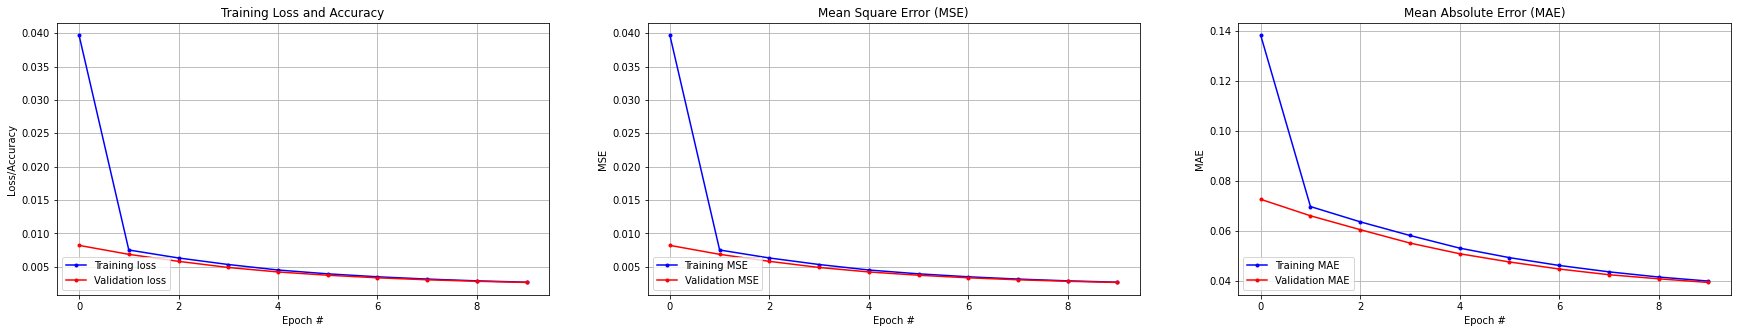

In [31]:
plt.figure(figsize=(30,5))
plt.subplot(131)
plt.plot(np.arange(0, 10), history.history["loss"], "b.-", label="Training loss")
plt.plot(np.arange(0, 10), history.history["val_loss"],"r.-", label="Validation loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.grid()

plt.subplot(132)
plt.plot(np.arange(0, 10), history.history["mse"], "b.-", label="Training MSE")
plt.plot(np.arange(0, 10), history.history["val_mse"], "r.-", label="Validation MSE")
plt.title("Mean Square Error (MSE)")
plt.xlabel("Epoch #")
plt.ylabel("MSE")
plt.legend(loc="lower left")
plt.grid()

plt.subplot(133)
plt.plot(np.arange(0, 10), history.history["mae"], "b.-", label="Training MAE")
plt.plot(np.arange(0, 10), history.history["val_mae"], "r.-", label="Validation MAE")
plt.title("Mean Absolute Error (MAE)")
plt.xlabel("Epoch #")
plt.ylabel("MAE")
plt.legend(loc="lower left")
plt.grid()

plt.show()

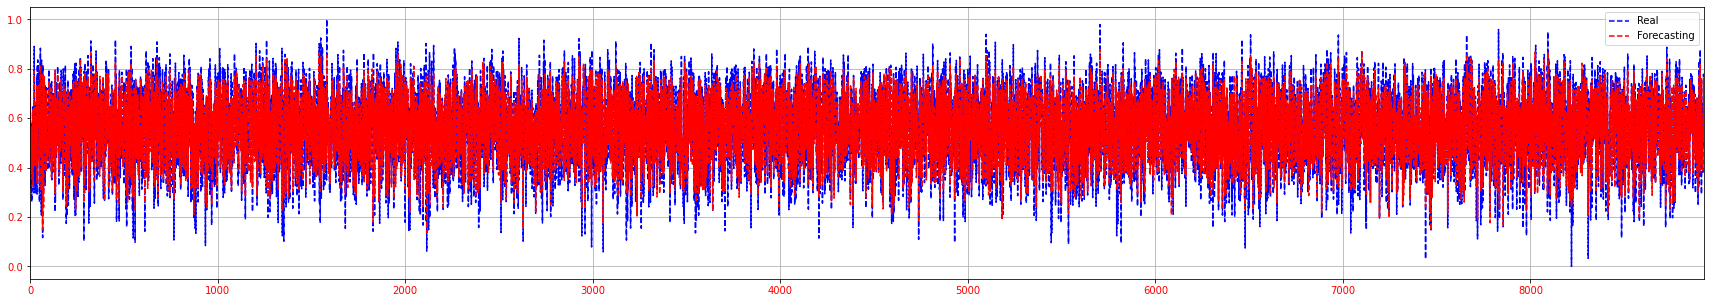

In [32]:
forecasting = model.predict(X_test)

plt.figure(figsize=(30,5))
plt.plot(y_test, c='b', label='Real', linestyle='--')
plt.plot(forecasting, c='r', label='Forecasting', linestyle='--')
plt.xlim(0,len(y_test))
plt.xticks(c='r')
plt.yticks(c='r')
plt.grid(True)
plt.legend()
plt.show()

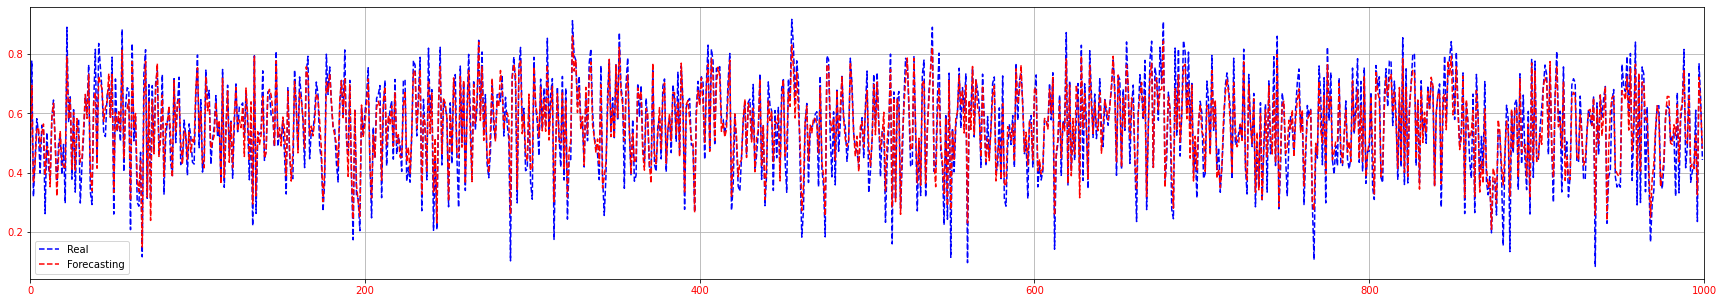

In [33]:
# Fragmento de los datos
plt.figure(figsize=(30,5))
plt.plot(y_test[0:1000], c='b', label='Real', linestyle='--')
plt.plot(forecasting[0:1000], c='r', label='Forecasting', linestyle='--')
plt.xlim(0,1000)
plt.xticks(c='r')
plt.yticks(c='r')
plt.grid(True)
plt.legend()
plt.show()

In [34]:
print("Mean Square Error (MSE): {}".format(mean_squared_error(y_test, forecasting, squared=False)))
print("Root Mean Square Error (MSE): {}".format(mean_squared_error(y_test, forecasting, squared=True)))
print("Mean Absolute Error (MAE): {}".format(mean_absolute_error(y_test, forecasting)))
print("R2: {}".format(r2_score(y_test, forecasting)))

Mean Square Error (MSE): 0.05121416226029396
Root Mean Square Error (MSE): 0.0026228902861475945
Mean Absolute Error (MAE): 0.03951476514339447
R2: 0.8898429037303472
